# Local Beverage Quality Classification  ~ Werner Pretorius

#### Imports

In [392]:
# Maths Stuff
import pandas as pd
import numpy as np
from scipy import stats as st

# Plotting Stuff
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing Stuff
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression

# Performance Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# To calculate class weights => combat label imbalance
from sklearn.utils.class_weight import compute_class_weight

#### Load the local-beverages.csv

In [393]:
bev_data = pd.read_csv("local-beverages.csv")

#### Display information as well as a descriptive statistics of the features

In [394]:
# Lets see what features we are working with
print(bev_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_1   1565 non-null   float64
 1   feature_2   1599 non-null   float64
 2   feature_3   1587 non-null   float64
 3   feature_4   1599 non-null   float64
 4   feature_5   1599 non-null   float64
 5   feature_6   1599 non-null   float64
 6   feature_7   1599 non-null   float64
 7   feature_8   1582 non-null   float64
 8   feature_9   1599 non-null   int64  
 9   feature_10  1599 non-null   float64
 10  feature_11  1599 non-null   float64
 11  feature_12  1599 non-null   int64  
 12  feature_13  1599 non-null   float64
 13  feature_14  1599 non-null   float64
 14  score       1599 non-null   int64  
dtypes: float64(12), int64(3)
memory usage: 187.5 KB
None


#### Print out stats sheet of ALL descriptive statistics

In [395]:
# First doctor the nulls before trying to derive descriptive stats from them
bev_data.fillna(bev_data.mean(), inplace=True)

# then print out those stats
for column in bev_data.drop(columns=["score"]).columns:
        print(f"Descriptive Stats Sheet for {column}:\n")
        print(f"- Location Stats:")
        print(f"Min: {np.amin(bev_data[column])}")
        print(f"Q1: {np.percentile(bev_data[column], 25)}")
        print(f"Mean: {round(np.mean(bev_data[column]), 2)}")
        print(f"Median: {np.median(bev_data[column])}")
        print(f"Q3: {np.percentile(bev_data[column], 75)}")
        print(f"Max: {np.amax(bev_data[column])}")
        print(f"\n- Dispersion Stats:")
        print(f"Variance: {round(np.var(bev_data[column]), 2)}")
        print(f"Std Deviation: {round(np.std(bev_data[column]), 2)}")
        print(f"Range: {round(np.max(bev_data[column]) - np.min(bev_data[column]), 2)}")
        print(f"Inter-Quartile Range: {round(np.percentile(bev_data[column], 75) - np.percentile(bev_data[column], 25), 2)}")
        print(f"\n=================================\n")

Descriptive Stats Sheet for feature_1:

- Location Stats:
Min: 4.6
Q1: 7.1
Mean: 8.33
Median: 8.0
Q3: 9.2
Max: 15.9

- Dispersion Stats:
Variance: 3.0
Std Deviation: 1.73
Range: 11.3
Inter-Quartile Range: 2.1


Descriptive Stats Sheet for feature_2:

- Location Stats:
Min: 0.12
Q1: 0.39
Mean: 0.53
Median: 0.52
Q3: 0.64
Max: 1.58

- Dispersion Stats:
Variance: 0.03
Std Deviation: 0.18
Range: 1.46
Inter-Quartile Range: 0.25


Descriptive Stats Sheet for feature_3:

- Location Stats:
Min: 0.0
Q1: 0.09
Mean: 0.27
Median: 0.26
Q3: 0.42
Max: 1.0

- Dispersion Stats:
Variance: 0.04
Std Deviation: 0.19
Range: 1.0
Inter-Quartile Range: 0.33


Descriptive Stats Sheet for feature_4:

- Location Stats:
Min: 0.9
Q1: 1.9
Mean: 2.54
Median: 2.2
Q3: 2.6
Max: 15.5

- Dispersion Stats:
Variance: 1.99
Std Deviation: 1.41
Range: 14.6
Inter-Quartile Range: 0.7


Descriptive Stats Sheet for feature_5:

- Location Stats:
Min: 0.54
Q1: 0.63
Mean: 0.75
Median: 0.73
Q3: 0.88
Max: 0.98

- Dispersion Stats:
Varia

#### Handle missing data

Since none of the features are Categorical-Nominal, i.e. they are Numerical-Continuous, instead of dropping the Null's, I opted for replacing them with the column mean

In [396]:
bev_data.fillna(bev_data.mean(), inplace=True)

# also just drop duplicates
bev_data = bev_data.drop_duplicates()

#### Correlate features against the label

<AxesSubplot:>

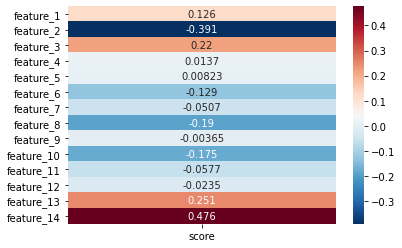

In [397]:
# first we build a matrix that contains the Pearson Correlation Coefficient (PCC) between features with reference to the labels
corr_matrix = bev_data.corr()

# next, we isolate the feature column in the matrix that corresponds to the labels
corr_matrix_labels = corr_matrix[["score"]].drop(labels=["score"])

# then generate a heatmap to see the correlations of features against the labels => based on the data we just isolated
sns.heatmap(corr_matrix_labels, annot = True, fmt="0.3", cmap = "RdBu_r")

<AxesSubplot:>

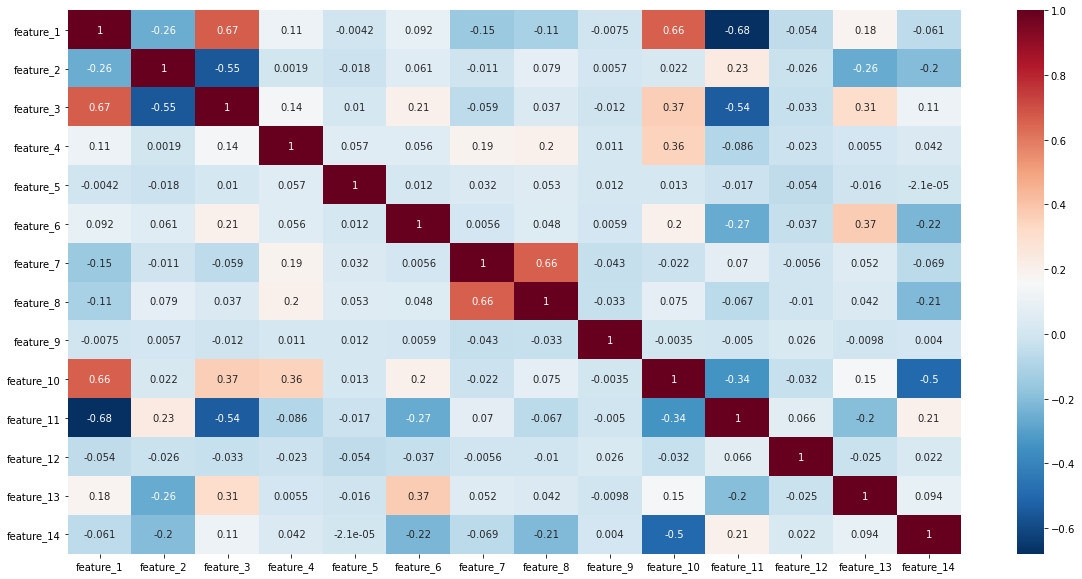

In [398]:
# heatmap for Feature to Feature Correlation
corr_matrix_features = bev_data.drop(columns=["score"]).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix_features, annot = True, cmap = "RdBu_r")

The reason for the Feature vs Feature heatmap is to spot high correlations between features, which we don't want (and luckily don't have). High corelation between two features would mean that we have a redundant feature, which means we would have to drop the one with the lowest correlation to the targets themselves.

#### Select top 11 features for your classification

In [399]:
# We will do this dynamically
# first, we reset the index of our score matrix so we can access those feature names
scores = corr_target.reset_index()

# next, order the rows based on their absolute values, in descending order based on those absolute score values
scores_ordered = scores.reindex(scores["score"].abs().sort_values(ascending=False).index)

# now to select the top 11 features based on the correlation scores
features_top_11 = bev_data[scores_ordered["index"][:11]]

#### Show a bar plot of the Beverage quality scores where the hight of the bar is the number of beverage with a specific score 

<AxesSubplot:xlabel='Specific Score', ylabel='Number of Beverages'>

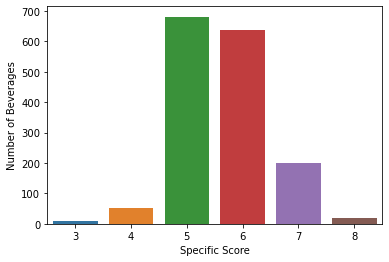

In [400]:
# get the score counts, 
score_num_counts = bev_data.score.value_counts().reset_index().rename(columns={"index": "Specific Score", "score": "Number of Beverages" })

# plot the bars
sns.barplot(x=score_num_counts["Specific Score"], y=score_num_counts["Number of Beverages"])

#### Define a label named **high_quality** such that 1 implies a high quality beverage while 0 implies a low quality beverage

In [401]:
# defining label
high_quality = bev_data["score"].apply(lambda score: 1 if score >= 7 else 0).to_frame().rename(columns={"score": "quality"})

#### How many instances of high_quality and low quality beverages are in your dataset?

In [402]:
# I LOVE playing with string interpolation...
score_counts = high_quality.value_counts().reset_index().rename(columns={0: "counts"})

print("Number of High and Low Quality Beverages in Dataset:")
print(f"Low Quality Beverages: {score_counts['counts'][0]}")
print(f"High Quality Beverages: {score_counts['counts'][1]}")


Number of High and Low Quality Beverages in Dataset:
Low Quality Beverages: 1382
High Quality Beverages: 217


TODO: I do not very much like this label imbalance... will have to do something about this.

#### Visualise features against classes

      feature_14  feature_2  feature_13  feature_3  feature_8  feature_10  \
0            9.4      0.700        0.56       0.00       34.0     0.99780   
1            9.8      0.880        0.68       0.00       67.0     0.99680   
2            9.8      0.760        0.65       0.04       54.0     0.99700   
3            9.8      0.280        0.58       0.56       60.0     0.99800   
4            9.4      0.700        0.56       0.00       34.0     0.99780   
...          ...        ...         ...        ...        ...         ...   
1594        10.5      0.600        0.58       0.08       44.0     0.99490   
1595        11.2      0.550        0.76       0.10       51.0     0.99512   
1596        11.0      0.510        0.75       0.13       40.0     0.99574   
1597        10.2      0.645        0.71       0.12       44.0     0.99547   
1598        11.0      0.310        0.66       0.47       42.0     0.99549   

      feature_6  feature_1  feature_11  feature_7  feature_12  quality  
0 

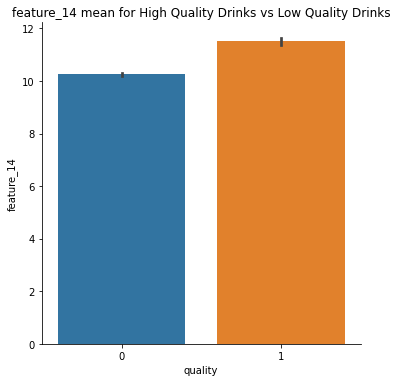

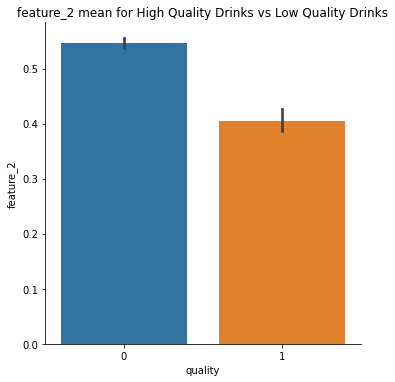

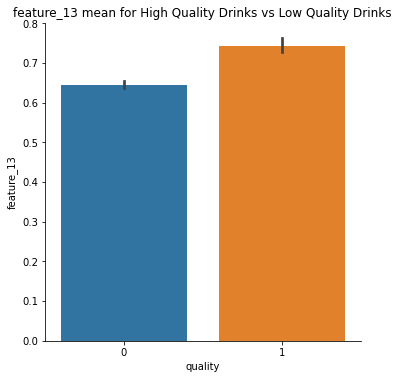

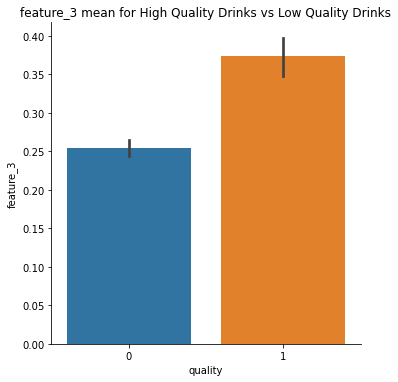

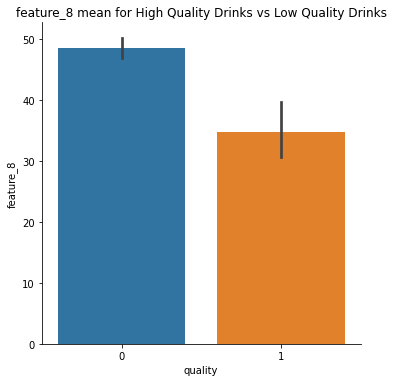

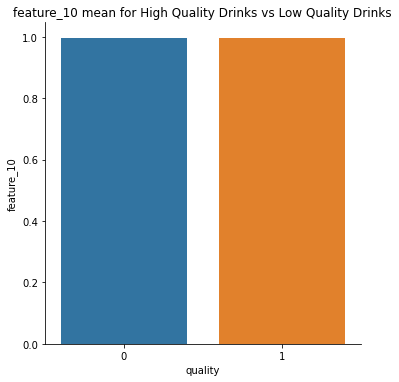

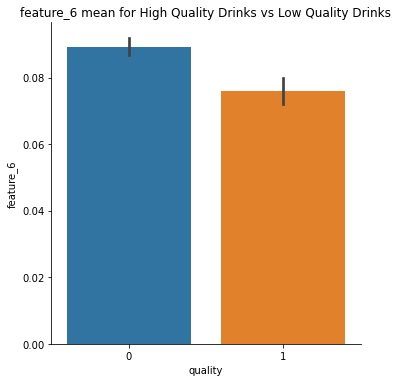

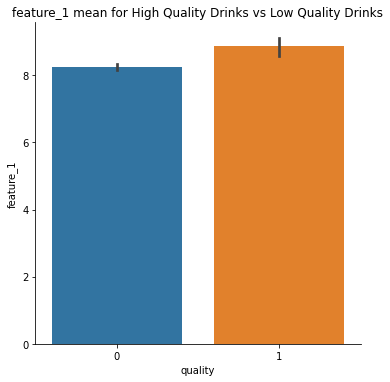

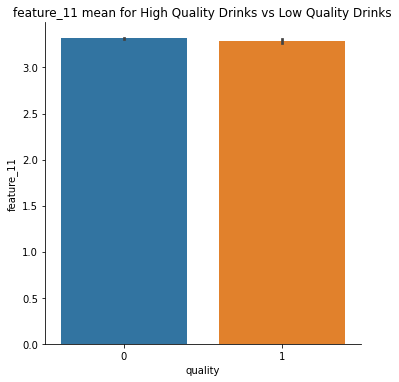

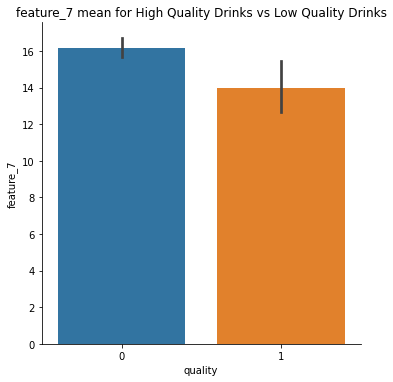

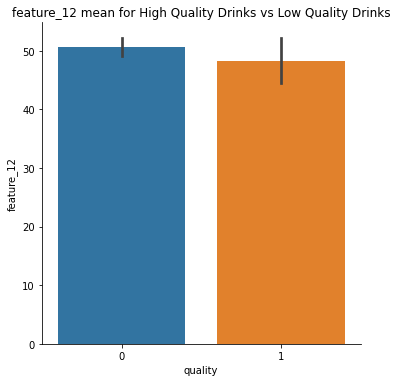

In [419]:
# for this lets keep to the top 11 features that we have identified

# for the purpose of ease I will joun to 11 features with our updated labels => new full dataset => will split them again later
bev_new = features_top_11.join(high_quality)
print(bev_new)

list_plots = []

# # make our plots for means of HQ vs Low Q drinks 
for column in features_top_11.columns:
    list_plots.append(sns.catplot(x='quality', y=column, data=bev_new, kind='bar').set(title=f"{column} mean for High Quality Drinks vs Low Quality Drinks"))


# Insights gained

The very first insight that i gained from assessing the bar graphs above, was that we can definitely reduce the dimensionality of our features drastically. In my opinion, from feature_8 (bar plot order) onwards. We can gain an interesting insight from observing which class contains higher values on average for a given feature by looking at the bar graphs above.

This is especially important, in my opinion, due to the fat that our features are not named, so we have no idea as to what they are indicative of based on the deduction that we would be able to make using the names. That is why we need to look at them is every way imaginable sothat we can better inderstand how they relate to the label. 

We can also look at thesee bar graphs to get a rudamentary feel of how the classes relate to one another based on the features. These graphs also indicate a rough correlation between the feature and the labels: the more the difference between the heights of two adjacent bars (0 and 1) the higher the correlation to the feature to the labels. If these heights were to be the same, it would indicate that the label has no dependancy on the feature, thus no correlation and the feature can be dropped to reduce noise.

## Logistic Regression
The logistic sigmoid function gives values in the range [0, 1], which can be used as probabilities for classification problems:

### Building a model
#### Separate x and y data

In [404]:
features = bev_new.drop(columns=["quality"])
labels = bev_new["quality"]

#### Get the training and testing sets. Use 25% of the data for testing

In [405]:
# setting random state to compare both models
rs = 69
x_train, x_test, y_train, y_test = train_test_split(features, labels, train_size = 0.75, test_size = 0.25, random_state = rs)

#### Rescale all numerical feature appropriately

In [406]:
# Center and standardize the data uzing Z - Scaler 
# Note: it appears as though Logistic regression model doesnt react well with MinMax Normalization

# x_train = MinMaxScaler().fit_transform(x_train)
# x_test = MinMaxScaler().fit_transform(x_test)

x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

As you can see, our scaler did its job beautifully, our new standard deviation is 1 and mean is practically 0

 #### Build and train  a Logistic Regression  model

In [407]:
logger = LogisticRegression().fit(x_train, y_train)

LogisticRegression()

#### Make predictions on the test set

In [408]:
y_pred = logger.predict(x_test)

#### Evaluate predictions using:
1. A confusion matrix to see how the model's predictions align with the actual class labels.
2. Accuracy to tell how many the model got right.

#### Confusion Matrix Evaluation

[[328   9]
 [ 48  15]]


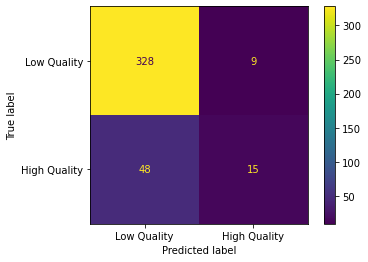

In [409]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

cm = confusion_matrix(y_test, y_pred, labels=logger.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Quality", "High Quality"])
disp.plot()
plt.show()

The confusion matrix takes the format:
- TN  FP
- FN  TP

The confusion matrix tells us the following things right off the bat:
- True Positives: the amount of times our model correctly predicted a 1
    - in our case (when I ran the code): 15 
- False Negatives: the number of times our model wrongly predicted 0, i.e. the answer was actually 1
    - in our case (when I ran the code): 28 
- True Negatives: the amount of times our model correctly predicted a 0
    - in our case (when I ran the code): 315 
- False Positives: the number of times our model wrongly predicted 1, i.e. the answer was actually 0
    - in our case (when I ran the code): 51 
    
Form here we can calculate a whole array of metrics to help us evaluate our model, more on that to follow.

#### Accuracy Score

In [410]:
print(f"Accuracy Score: {round(accuracy_score(y_test, y_pred), 2)}")

Accuracy Score: 0.86


As can be seen off the score sheet, or calculated off of the confusion matrix to the same effect, the accuracy score for the model is brilliantly high. This ultimately means that our model predicts correctly 90% of the time. It is, however not the only performance metric that we should pay close attention to, especially considering the label imbalance of our data. The model will easily predict a new test sample as Low Quality, while completely overlooking the High Quality class. So in this case, we should take the accuracy score with a pinch of salt as it may mislead the untrained eye into thinking that the model is performing flawlessly. The accuracy score is NOT impervious to bias.

#### Provide comments on the performance of your model 

Score Sheet:
Score Model on Data: 0.86
Accuracy Score: 0.86
ROC Area Under Curve: 0.61

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       337
           1       0.62      0.24      0.34        63

    accuracy                           0.86       400
   macro avg       0.75      0.61      0.63       400
weighted avg       0.83      0.86      0.83       400



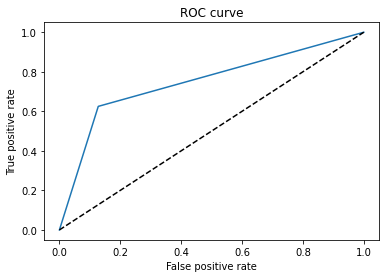

In [411]:
print("Score Sheet:")
print(f"Score Model on Data: {round(logger.score(x_test, y_test), 2)}")
print(f"Accuracy Score: {round(accuracy_score(y_test, y_pred), 2)}")
print(f"ROC Area Under Curve: {round(roc_auc_score(y_test, y_pred), 2)}\n")
print(classification_report(y_test, y_pred))
    
    
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

Although the accuracy score on the model is very high, the other metrics are rather worrysome. Our precision scores in the middle, while the recall (true positive rate) is rather low, this means that our model is missing a lot of positive classifications in terms of high quality beverages, and too easily labels them as low quality, the area under the ROC curve is also very low. These poor evaluation ratings can possible be ascribed to the 6.358:1 label imbalance in favour of the Low Quality class. It should be noted here that I based my evualation on the macro-averages provided by the classification report.

So far, not bad, but the model is not yet giving me what I'm looking for. In the following section, I will list a few issues that I feel need to be addressed then I will look for ways to tackle them.

# Fine tune the model 

Firstly, should discard the arbitary selection of the top 11 features to train our data. We should actually assess and evaluate the scores. A good rule of thumb is to discard features that possess a correlation(c) with an absolute value of c < 0.3, in other words -0.3 < c < 0.3 . 

Secondly, the threshold specified for the binarization of beverage scores (< 7) is extremely high considering the spread of the data. The model would have to be tweaked in order to give the recall a boost sothat the model can compensate for this, provided that the beverage company has any aspiration to have positive classifications. But at the moment, the model overlooks the high quality class around 50-70% of the time roughly. I almost decided on designing a Preceptron to try and combat this and alter the weights iteratively, but due to time constraints I had to decide against this.

Thirdly, the test set size is too large (25% of the dataset). Remember, the High Quality Class(1) makes up roughly 15% of the entire dataset, so it is more than possible and quite probable for the testing set so swallow such a large chunk of this class such that it will create seriously biased, inaccurate and ultimately misleading and misrepresentative training data, which in turn leads to a flawed predictive model. 

# Logistic Regression: Take 2

#### Lets try implement a few tweaks to combat these issues, and see where it takes us. 

In [412]:
# create now features and labels, in case I want to modify their contents & dimentionality

features_w = bev_new.drop(columns=["quality"])
labels_w = bev_new["quality"]

# create new training and testing sets with slightly altered train and test protions
x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(features_w, labels_w, train_size = 0.85, test_size = 0.15, random_state=rs)


# Center and standardize the data uzing Z - Scaler 
# Note: it appears as though the Logistic regression model doesnt react well with MinMax Normalization

x_train_w = StandardScaler().fit_transform(x_train_w)
x_test_w = StandardScaler().fit_transform(x_test_w)

#### Taking a chance: Catering for the label imbalance => weighting the labels

In [413]:
# create weights to ascribe to each label class to cater for the almost 7:1 label imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=[0,1], y=labels_w)

In [414]:
# instantiate a new logistic regression model using the class weights
logger_weighted = LogisticRegression( class_weight={1: class_weights[1], 0: class_weights[0]})
logger_weighted.fit(x_train_w, y_train_w)

y_pred_w = logger_weighted.predict(x_test_w)

Now to test the change!

[[168  39]
 [  4  29]]


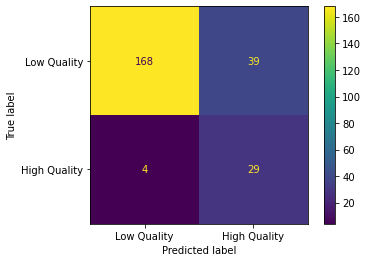

In [415]:
conf_mat_w = confusion_matrix(y_test_w, y_pred_w)
print(conf_mat_w)

cm = confusion_matrix(y_test_w, y_pred_w, labels=logger_weighted.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Quality", "High Quality"])
disp.plot()
plt.show()

Score Sheet:
Score Model on Data: 0.82
Accuracy Score: 0.82
ROC Area Under Curve: 0.85

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       207
           1       0.43      0.88      0.57        33

    accuracy                           0.82       240
   macro avg       0.70      0.85      0.73       240
weighted avg       0.90      0.82      0.84       240



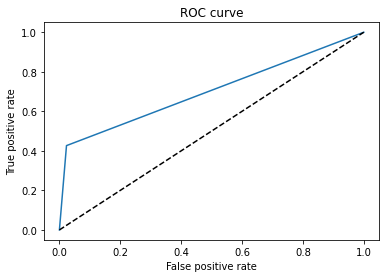

In [416]:
print("Score Sheet:")
print(f"Score Model on Data: {round(logger_weighted.score(x_test_w, y_test_w), 2)}")
print(f"Accuracy Score: {round(accuracy_score(y_test_w, y_pred_w), 2)}")
print(f"ROC Area Under Curve: {round(roc_auc_score(y_test_w, y_pred_w), 2)}\n")
print(classification_report(y_test_w, y_pred_w))
    
    
fpr, tpr, thresholds = roc_curve(y_pred_w, y_test_w)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#### Observations & Comments

Please Note, variations could occur due to the nature of our dataset as described above. it is thus imperative to not compare the the two models off of one trial alone. Several trials were run to draw up the observations that were to ultimately determine my conclusions. Also note, the current random state may vary from these observations.

Overall, one can observe a slight increase in certain score metrics. A slight variation beween the first and second model can be observed with regard to accuracy reduction, however, this variation might just be a trade off to consider. The ROC AUC (Area Under Curve) has increased daramatically which shows a massive increase in the model's ability to distinguish between classes. Precision score for the second model seems to have picked up on average but still needs working on. The recall score (True Positive Rate) has made a dramatic increase as could be expected. What this means is that the model will now much less likely miss the correct classification of high quality beverages. Because of this spike in Recall, we can now also observe a slight increase in F1.

All in all, I am impressed with the increase in performance resulting from the changes that I implemented. Although slight, any imporovement is good and should not be overlooked. It is safe to say that the model now performs better than it did before the label imbalance was countered.